## Programming for Analytics -- Homework Assignment 3
## "Where is the Music Market Trending Towards?"

#### Name: Yufeng Huang
#### Email: yufeng.huang@simon.rochester.edu
#### Date: 8/15/2024


## 0. General Objective
In this assignment, we will continue to work with the Billboard data, building upon the foundation laid in previous assignments. However, instead of focusing on a single artist (like Taylor Swift), we will analyze a broader range of artists and their performance over time. Our objective is to gain insights into the evolution of music popularity and genre dominance across decades.


To begin, we will first read and process all billboard data similar to Assignment 2. As you see, we now read the data from 1967. Adjust the file directory as needed. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Read billboard data as in Assignment 2
billboard_ranking = pd.DataFrame()
for yr in range(1967, 2021):
    temp_data = pd.read_csv(f"../6_2_assignment_2/py-billboard200/billboard-200-{yr}.csv", on_bad_lines="skip")
    temp_data = temp_data[["date", "title", "artist", "current"]]   # keep columns
    temp_data["date"] = pd.to_datetime(temp_data["date"], format="%Y-%m-%d")
    temp_data.rename(columns={"current": "ranking"}, inplace=True)
    billboard_ranking = pd.concat((billboard_ranking, temp_data), axis=0)

billboard_ranking.head()

,date,title,artist,ranking
0,1967-12-30,"Pisces, Aquarius, Capricorn, And Jones Ltd.",The Monkees,1
1,1967-12-30,Diana Ross And The Supremes Greatest Hits,Diana Ross & The Supremes,2
2,1967-12-30,Sgt. Pepper's Lonely Hearts Club Band,The Beatles,3
3,1967-12-30,Magical Mystery Tour (Soundtrack),The Beatles,4
4,1967-12-30,Their Satanic Majesties Request,The Rolling Stones,5


## 1. Who are the top artists in each decade?
1a. For each artist, calculate a score based on their ranking on the Billboard charts using the formula:

`score = 200 − ranking`

This score reflects the artist's performance, with higher rankings contributing to a higher score.

1b. Generate Decade Information:

Extract the decade from the date of each Billboard entry. For instance, if the date is `1997-05-01`, the corresponding decade should be `1990` (as an integer). Similarly, a date like `2015-06-11` should correspond to the decade `2010`.

1c. Create a Decade-wise Artist Score DataFrame:

Create a DataFrame that aggregates the scores for each artist within each decade. The key of this dataset should be at the artist-decade level. The scores will reflect both the frequency of the artist's appearance on the Billboard and the rankings they achieved.

1d. Identify the Most Popular Artists by Decade:

- Determine the most popular artists in each decade (1970s, 1980s, 1990s, 2000s, and 2010s).
- You might want to exclude popular non-artist names such as "Various Artists" and "Soundtrack."
- Create a bar plot for each decade showing the scores of the top 25 artists, with the artist's name on the x-axis. To handle long artist names, rotate the labels by 90 degrees using `plt.xticks(rotation=90)`.

In [4]:
# Write your code from 1a to 1d here. Feel free to use multiple cells.

# 1a - calculate score
billboard_ranking["score"] = 200 - billboard_ranking["ranking"]

# 1b - generate decade
billboard_ranking["year"] = billboard_ranking["date"].dt.year
billboard_ranking["decade"] = (np.floor(billboard_ranking["year"] / 10) * 10).astype(int)

# 1c - sum across weeks to create artist-decade level scores
score_artist_decade = billboard_ranking.groupby(["artist", "decade"], as_index=False).agg({"score": "sum"})
score_artist_decade.head()


,artist,decade,score
0,!!! (Chk Chk Chk),2000,5
1,$NOT,2020,28
2,$uicideBoy$,2010,449
3,$uicideBoy$,2020,286
4,'68,2010,91


COMMENT 1: vectorized calculations
- score = 200 - rank (obviously vectorized)
- year is dt.year (vectorized), otherwise need to mess with strings and mess with the .apply method
- decade -- one often has to be "smart" in rounding years to decade, rounding minute to 10 minute, etc. Most of these can be done via simple vectorized calculations.

In [19]:
# 1d - plot popularity over time

# Find the top k artist in terms of the score
def find_top_artists(dec, k):
    local_dat = score_artist_decade[score_artist_decade["decade"] == dec].sort_values("score", ascending=False)
    local_dat = local_dat[~(local_dat["artist"].isin({"Soundtrack", "Various Artists"}))]      # drop soundtrack and VA, which is not an artist
    local_dat = local_dat.iloc[np.arange(k), :]    # keep rank 0-99
    local_dat["artist"] = local_dat["artist"].str[:15]  # cut artists off if string too long
    return (local_dat["artist"], local_dat["score"])

# Make the plot also a function
def plot_top_artists(dec, k):
    (artist, score) = find_top_artists(dec, k)
    plt.figure()
    plt.bar(artist, height=score)
    plt.ylabel("sum of (200 - ranking)")
    plt.title(f"top {k} artists in the {dec}s")
    plt.xticks(rotation=90)


COMMENT 2: I avoided copy-pasting this step many times by writing a function. 

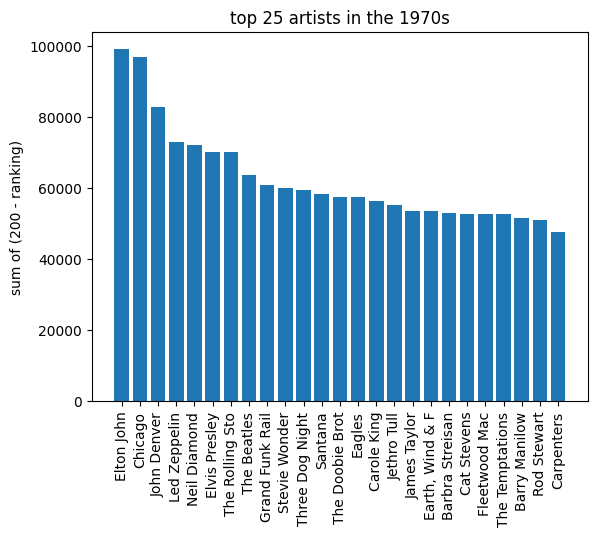

In [20]:
# plot - 1970, 1980, 1990, 2000, 2010, 2020 -- create six plots in plt
K = 25
plot_top_artists(1970, K)

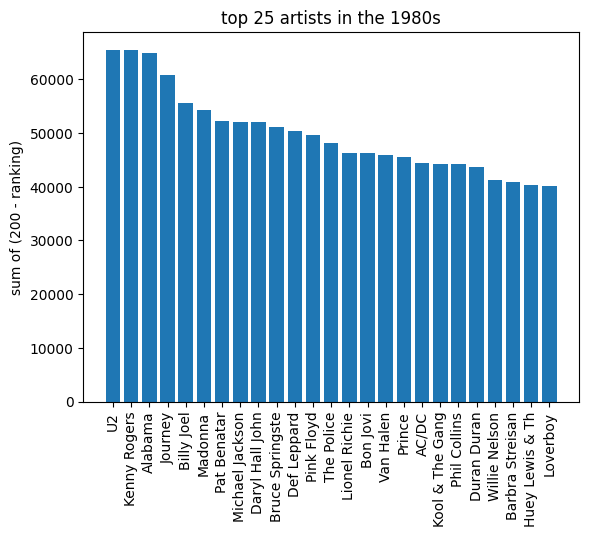

In [21]:
plot_top_artists(1980, K)

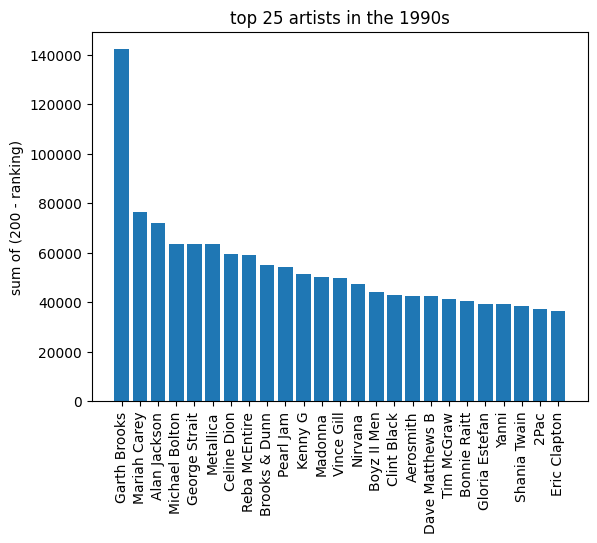

In [22]:
plot_top_artists(1990, K)

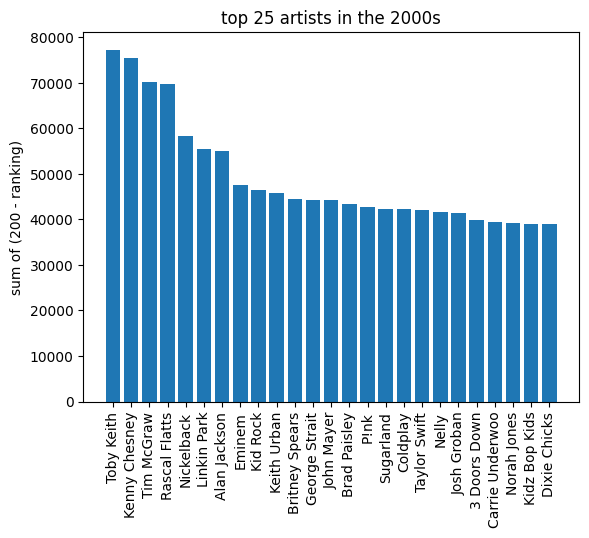

In [23]:
plot_top_artists(2000, K)

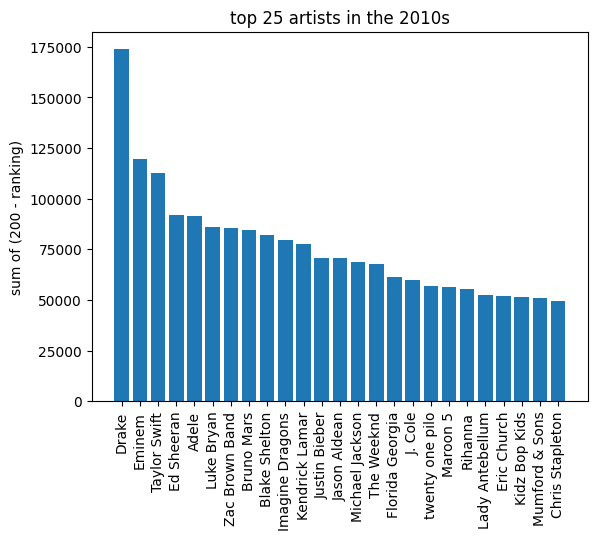

In [24]:
plot_top_artists(2010, K)

## 2. Which are the most popular genres in each year?

We have an additional dataset, `billboard_genres.csv`, that contains genre information for some artists. For example, Taylor Swift's genre might be listed as `['folk', 'country', 'pop']`.

2a. Merge the genre information into the Billboard data, determining the appropriate key for the merge. After merging, drop any unmatched observations.

2b. For the genres "rock," "pop," "metal," "jazz," and "punk," sum the scores across all artists whose genre list includes these terms. Perform this calculation for each year, resulting in one observation per year containing the summed scores for these five genres.
- hint 1: you might want to first create a boolean variable that take `1` (or `True`) if the artist contains a genre (e.g., rock). Then, we can multiply score with this boolean variable to include only the scores for artists in this genre
- hint 2: to create this boolean variable. You can create a function and use `.apply`. Or you can loop. If you loop, do not loop at the billboard data because that data would be at the artist-week level. Loop at the genre data first (that's a smaller dataset). Even better, first find artists that ever go on the billboard data at all before you loop

2c. Create a plot that visualizes the sum of scores for each of the five genres ("rock," "pop," "metal," "jazz," and "punk") over the years 1967-2020.


In [56]:
# Write your code from 2a to 2c here. Feel free to use multiple cells.

# 2a - merge genre
genre_data = pd.read_csv("./data/billboard_genres.csv")
billboard_ranking_merged = pd.merge(billboard_ranking, genre_data, left_on="artist", right_on="name", how="inner")

In [34]:
billboard_ranking_merged.head()

,date,title,artist,ranking,score,year,decade,name,genre
0,1967-12-30,"Pisces, Aquarius, Capricorn, And Jones Ltd.",The Monkees,1,199,1967,1960,The Monkees,"['rock', 'pop']"
1,1967-12-30,Sgt. Pepper's Lonely Hearts Club Band,The Beatles,3,197,1967,1960,The Beatles,"['rock', 'pop']"
2,1967-12-30,Magical Mystery Tour (Soundtrack),The Beatles,4,196,1967,1960,The Beatles,"['rock', 'pop']"
3,1967-12-30,Their Satanic Majesties Request,The Rolling Stones,5,195,1967,1960,The Rolling Stones,"['rock', 'pop', 'blues']"
4,1967-12-30,Strange Days,The Doors,9,191,1967,1960,The Doors,"['rock', 'pop']"


In [58]:
# 2b -- apply approach

# first write a function that checks if a genre is in a list
def check_genre(lst):
    return gen in lst

# then generate the boolean that indicate whether this artist contains this genre
genre_list = ["rock", "pop", "metal", "jazz", "punk"]
for gen in genre_list:
    billboard_ranking_merged[f"score_times_{gen}"] = billboard_ranking_merged["score"] * billboard_ranking_merged["genre"].apply(check_genre)

# then sum over these scores by genre
score_by_genre_year = billboard_ranking_merged.groupby("year", as_index=False).agg({f"score_times_{x}": "sum" for x in genre_list})


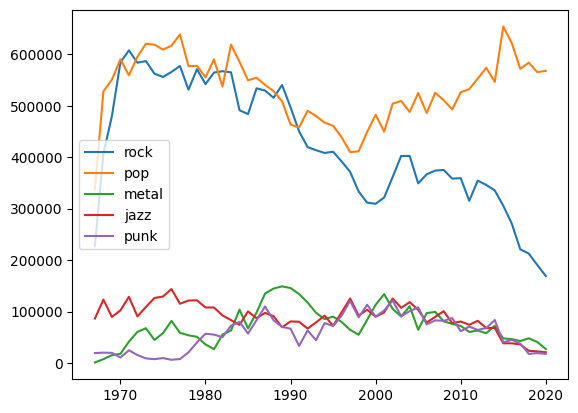

In [70]:
# 2c - plot score
plt.figure
for gen in genre_list:
    plt.plot(score_by_genre_year["year"], score_by_genre_year[f"score_times_{gen}"], label=f"{gen}")
plt.legend()

In [44]:
# note 1: {f"score_times_{x}": "sum" for x in genre_list}

In [ ]:
# note 2: billboard_ranking_merged["genre"].apply(check_genre)

In [75]:
# note 3: for loop version
genre_data = pd.read_csv("./data/billboard_genres.csv")
genre_list = ["rock", "pop", "metal", "jazz", "punk"]
def check_genre(lst):
    return gen in lst

# first shrink genre data, reset_index is crucial because we're using .loc with numeric indices...
unique_artists = billboard_ranking["artist"].unique()
genre_data_sub = genre_data[genre_data["name"].isin(unique_artists)].reset_index(drop=True)

# loop is a bit slow, but if we're working with genre_data_sub we should be fine
for gen in genre_list:
    for i in range(len(genre_data_sub)):
        genre_data_sub.loc[i, f"is_{gen}"] = check_genre(genre_data_sub.loc[i, "genre"])

# merge with billboard now
billboard_ranking_merged = pd.merge(billboard_ranking, genre_data_sub, left_on="artist", right_on="name", how="inner")

# generate score_times_... 

# .groupby.agg

# plot



COMMENT 3: this is a somewhat tricky question. We have to be smart about this, otherwise the loop will take forever.
- Do I loop over all observations in the merged data? -- no because redundant calculations are done repeatedly for a given artist
- Do I loop over all artists? -- no because redunant calculations are done for artists that never make it to the billboard
- Then I realized -- I can first get the people who are in the list of billboard artists and then work on those people...